<a href="https://colab.research.google.com/github/Platinum-Dragon/Ore-detector-presentation/blob/main/Ore_Detector_Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Algorithm has Promise in Learning to Detect Ore Through Discoloration in Visible Light

Satellite images are already used to identify potential sources of minerals and ore by scanning the images for signature light frequencies that are reflected from the terrain where the ore may be present.

We trained a CNN to recognize terrain containing quartz deposits from satellite images with 66.5% (+/- 1.5%) accuracy.

The idea for this project was inspired by this paper:
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016GC006501
where light signatures were being used to detect the presence of various mineral ores.

Below is the procedure we used.
First, we make sure we have some essential packages installed:

In [ ]:
!pip install pillow
!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install sklearn

Next, import some necessary packages:

In [1]:
import os
from PIL import Image
import requests
import numpy as np
import pandas as pd

In [2]:
print(f"TPU address-> grpc://{os.environ['COLAB_TPU_ADDR']}")

TPU address-> grpc://10.120.215.10:8470


Let's mount our Google Drive so that we can store our data and share it if need be, and also define the path that we will store our satellite images in.

This Colab will store a root path in order to know where to look for any files
needed during operation.

If your path is different than:
"/content/drive/My Drive/Colab Notebooks/Ore Detector/"
then you will have to modify it accordingly

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# This is the working directory for this Colab
ROOT_PATH = "/content/drive/My Drive/Colab Notebooks/Ore Detector/"

# provide link to download our image datset.

# These global variables will allow you to change the directories that the 
# satellite images will be written to or the coordinate dataset will be read
# from.
SAT_IMG_DIR = "SatImages/"
LAT_LONG_DIR = "Lat Long Datasets/"


Mounted at /content/drive


Now, let's go get some satellite images. We already have a dataset of latitude and longitude coordinates of known mineral sources, some containing quartz and some not, stored in a csv file. So for each set of coordinates we need to fetch its corresponding image.

To fetch each image, we will be using Google Static Maps API, and you will need an API key to use it.

Here is how to get your API key:https://developers.google.com/maps/documentation/embed/get-api-key

When you have your API key, place it in a folder in the Ore Detector directory called:
"map_apikey" and the Colab will look for it there.

A call to Google Static Maps API will give us our image. The data row already has a column indicating whether there is quartz or not, so we can save the image to the "quartz" directory if it has quartz, and the "notquartz" directory if not.

In [ ]:
# TODO change the key to a constant, provide link explaining how they
# can get their own key and then read key from local folder.

'''
This cell will fetch the satellite image for each of the coordinates listed
in the dataset
'''
# Set this flag to true if the image data needs to be reconstructed again.
BUILD_IMAGE_DATA = False

if BUILD_IMAGE_DATA:
  GOOGLE_STATIC_MAPS_ADDY = "https://maps.googleapis.com/maps/api/staticmap?"
  dfMineral = pd.read_csv(f"{ROOT_PATH}{LAT_LONG_DIR}MagnetiteLatLong.csv")

  # First get the API key for calling Google Maps
  try:
    with open(f"{ROOT_PATH}map_apikey", "r") as f:
      MAPS_API_KEY = f.read()
  except FileNotFoundError:
    print("API key file not found")
    exit(-1)

  # Parameter list for map image call
  picSize = "600x600"
  zoomLevel = 7
  # mapType = satellite
  # key = MAPS_API_KEY

  # For each location in the data frame, obtain the satellite picture for
  # that location and write it to the appropriate directory.
  for i in range(0, dfMineral.shape[0]):
    # Construct the URL for the image at these coordinates
    url = GOOGLE_STATIC_MAPS_ADDY + \
          f"center={dfMineral.loc[i, 'latitude']},{dfMineral.loc[i, 'longitude']}" + \
          f"&size={picSize}" + \
          f"&zoom={zoomLevel}" + \
          "&maptype=satellite" + \
          f"&key={MAPS_API_KEY}"

    # Request and save one picture at this URL
    response = requests.get(url)

    if response.status_code == 200:
    # If the fetch is successful, save the image in the appropriate directory

      if dfMineral.loc[i, 'magnetite']:
        path = ROOT_PATH + SAT_IMG_DIR + f"mineral/mg{i}.png"
      else:
        path = ROOT_PATH + SAT_IMG_DIR + f"nomineral/nmg{i}.png"

      with open(path, 'wb') as f:
        f.write(response.content)
    

Now that we have our images, we need to build our actual training and validation data. First, we will import these Pytorch libraries because we will need the transform function to resize our pictures and keep them in a format that Pytorch will be able to work with. We also import the necessary modules for building and training the CNN.

In [4]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns

Here, we set up some constants including a resize function. We will read each of the images in the quartz folder, resize it to 50 x 50 and append it to our list of training data. We will do the same with the notquartz pictures so that we have our labeled training data. Finally, the data is saved so that we can load it in when we are ready to train.

In [5]:
'''
This cell will take the images in the quartz or notquartz directories,
resize them, and create a list of images with their respective labels
for use in training and validation.
'''
MAKE_TRAINING_DATA = False

class MineralOrNot ():
  MINERAL = ROOT_PATH + SAT_IMG_DIR + "quartz"
  NOT_MINERAL = ROOT_PATH + SAT_IMG_DIR + "notquartz"
  LABELS = {NOT_MINERAL: 0, MINERAL: 1}
  RESIZE_SIZE = 50
  trainingData = []
  resize = T.Resize(RESIZE_SIZE, interpolation=Image.BICUBIC)
  # resize = T.Compose([T.Resize(RESIZE_SIZE, interpolation=Image.CUBIC)])

  def makeTrainingData(self):
    for label in self.LABELS:
      for f in os.listdir(label):
        imgPath = os.path.join(label, f)
        img = Image.open(imgPath).convert("RGB")
        # image will be resized here
        im = self.resize(img)
        # Make labels a single vector 1 = mineral, 0 = no mineral
        self.trainingData.append([np.array(im), self.LABELS[label]])
        '''
        Create 3 more versions of the image each rotated 90 degrees to
        increase the tranining data:
        '''
        # for i in range(3):
        #   im = TF.rotate(im, 90)
        #   self.trainingData.append([np.array(im), self.LABELS[label]])

        # The line below was to one-hot encode the labels, but the layer
        # is expecting a 1D vector. 
        # self.trainingData.append([np.array(im), np.eye(2)[self.LABELS[label]]])

    np.random.shuffle(self.trainingData)
    np.save(f"{ROOT_PATH}training_data.npy",
            self.trainingData)

if MAKE_TRAINING_DATA:
  allData = MineralOrNot()
  allData.makeTrainingData()
  print(f"Training data length: {len(allData.trainingData)}")



#Load the Training Data

In [ ]:
#Simply loading our labeled dataset into this variable
trainTestDataset = np.load(f"{ROOT_PATH}training_data.npy",
                           allow_pickle=True)

print(len(trainTestDataset))


2308


The data is divided into 90% training and 10% validation data

In [ ]:
# Train test split
X = [x[0] for x in trainTestDataset]
y = [y[1] for y in trainTestDataset]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)


In [ ]:
print(f"Shape of X train element: {X_train[0].shape}")
print(f"First y train element: {y_train[0]}")
print(f"Len of X train: {len(X_train)}")
print(f"Len X val: {len(X_val)}")

# Build the Model
A 2-layer CNN with 3x3 kernels is built using Pytorch functions. This very simple setup was chosen so that we could quickly get an indication if our idea was on track.

In [ ]:
class CNNMine(nn.Module):
    def __init__(self):
      super(CNNMine, self).__init__()
      linear_input_size = 432
      self.cnn_layers = nn.Sequential(
        # Defining FIRST 2D convolution layer
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Defining SECOND 2D convolution layer
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(linear_input_size, 2)
      )

    def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x



This function will train the model for the desired number of epochs. 100 epochs were performed in order to see if/when the training and validation data converged. The Adam optimizer was chosen here because it was the quickest and simplest to implement for our discovery purposes.

In [ ]:
def train_model(epochs, model):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
      optimizer = Adam(model.parameters(), lr=0.07)
      criterion = nn.CrossEntropyLoss()
      model.train()
      tr_loss = 0
      ptX_train = Variable(torch.tensor(X_train)).float()
      # The model is expecting Batch, Channel, Width, Height so our
      # tensor needs to be rearranged
      ptX_train = ptX_train.permute(0, 3, 1, 2)
      pty_train = Variable(torch.tensor(y_train)).float()
      ptX_val = Variable(torch.tensor(X_val)).float()
      # The model is expecting Batch, Channel, Height, Width so
      # rearrange here also
      ptX_val = ptX_val.permute(0, 3, 1, 2)
      pty_val = Variable(torch.tensor(y_val)).float()
      optimizer.zero_grad()
      output_train = model(ptX_train)
      output_val = model(ptX_val)
      loss_train = criterion(output_train, pty_train.squeeze().long())
      loss_val = criterion(output_val, pty_val.squeeze().long())
      train_losses.append(loss_train)
      val_losses.append(loss_val)
      loss_train.backward()
      optimizer.step()
      tr_loss = loss_train.item()
      if epoch%5 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
      # plotting the training and validation loss
    start_time = time.time()
    print('Predicting training set')
    predict_set(ptX_train, pty_train, model)
    end_time = time.time()
    print('Prediction of ' + str(len(ptX_train)) + ' samples took ' + str(end_time - start_time) + ' seconds')
    print('Predicting validation set')
    predict_set(ptX_val, pty_val, model) 
    # test_x = Variable(torch.tensor(model.test_x).unsqueeze(1)).float()
    # test_y = Variable(torch.tensor(model.test_y).unsqueeze(1)).float()
    # print('Predicting test set')
    # predict_set(test_x, test_y, model)
    torch.save(model.state_dict(), f"{ROOT_PATH}oremodel.pt")
    plt.figure(figsize=[15,12])
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()

These functions are used to call the training function and to asses the accuracy of the model after the last training epoch has been completed.

In [ ]:
def train_ore_detector(model = None, epochs=100, w = 800, h = 600):
  if model == None:
    model = CNNMine()
  # model.load_training_data()
  train_model(epochs, model)

def predict_set(set_values, labels, model):
    predictions = has_ore(set_values, model)
    print(str(accuracy_score(labels, predictions)*100) + '% accuracy on target dataset')

def has_ore(value, model):
    with torch.no_grad():
        output = model(value)
    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    return np.argmax(prob, axis=1)

#Train the Detector

Below, we show the output of one training run. The blue line represents the loss on the training phase, while the orange line represents the loss validation phase. We can see that they gradually decrease together, finally achieving their minimums.

The values are close together and do converge around 100 epochs, suggesting that 100 epochs is sufficient to train this model on this dataset.

This training step was run multiple times and the average was taken in order to get a figure for the model's accuracy.


Epoch :  1 	 loss : tensor(0.8264, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(0.9321, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(0.6589, grad_fn=<NllLossBackward>)
Epoch :  16 	 loss : tensor(0.7502, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(0.6533, grad_fn=<NllLossBackward>)
Epoch :  26 	 loss : tensor(0.7244, grad_fn=<NllLossBackward>)
Epoch :  31 	 loss : tensor(0.6567, grad_fn=<NllLossBackward>)
Epoch :  36 	 loss : tensor(0.7220, grad_fn=<NllLossBackward>)
Epoch :  41 	 loss : tensor(0.6578, grad_fn=<NllLossBackward>)
Epoch :  46 	 loss : tensor(0.7207, grad_fn=<NllLossBackward>)
Epoch :  51 	 loss : tensor(0.6528, grad_fn=<NllLossBackward>)
Epoch :  56 	 loss : tensor(0.7117, grad_fn=<NllLossBackward>)
Epoch :  61 	 loss : tensor(0.6498, grad_fn=<NllLossBackward>)
Epoch :  66 	 loss : tensor(0.6904, grad_fn=<NllLossBackward>)
Epoch :  71 	 loss : tensor(0.6416, grad_fn=<NllLossBackward>)
Epoch :  76 	 loss : tensor(0.7088, grad_fn=<NllLossBackw

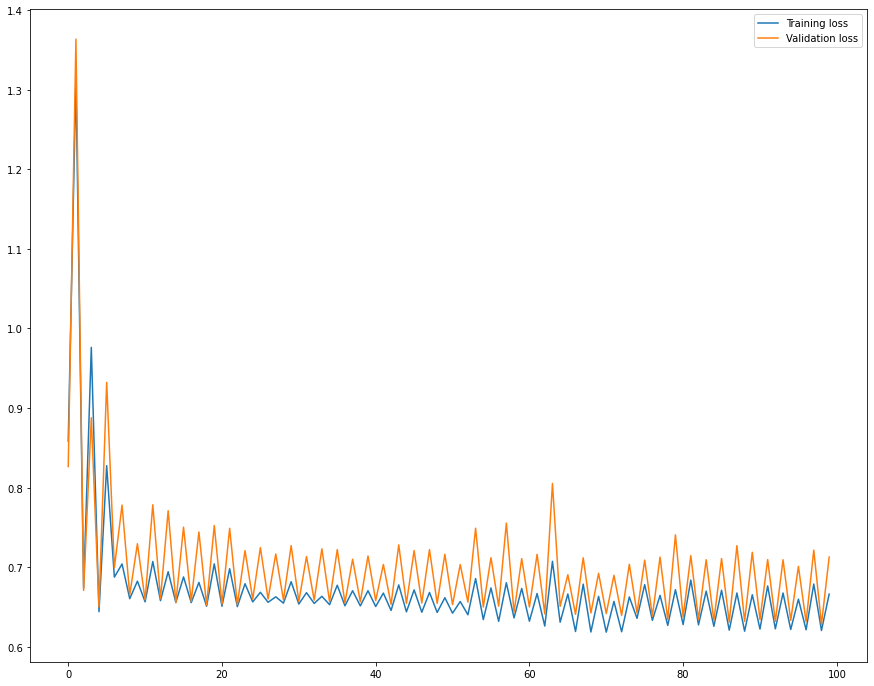

In [ ]:
train_ore_detector()

Our goal was to achieve > 60% accuracy to determine if we should move forward with this project. We achieved > 60% accuracy with the two ore types tested (quartz and magnetite). Several runs were done and their average was taken to determine this metric. This suggests that we should move forward with a production-ready implementation.

Explain occlusion testing/heatmap. What it is, how we did it, what do the results mean?

In order to test which neurons are being the most activated during each classification, we must perform occlusion testing. That is, block part of the image, make a prediction, then plot the neuron activations as colors on a heatmap. Block the next segment and repeat.

The result will be a heatmap with the darkest regions showing the most important neurons in that image for determining the classification.

In [ ]:
'''
Code to perform occlusion and assess the results
'''
# Set this to get the nth picture in the dataset
# A heatmap will be generated as well as the image shown via matplotlib
IM_NO = 14

def occlusion(model, image, label, occ_size = 10, occ_stride = 10, occ_pixel = 0.5):
    '''
    Our images are only 50 x 50. In this code example the occlusion size and stride
    were originally 50 and 50. Since our images are 1/5 the size of the VGG
    images this was based on (128 x 128) then we shall choose numbers in the same
    proportion i.e. occ_size 10 and occ_stride 10
    '''

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[IM_NO][label]

            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap
  
  

Load our trained model to perform occlusion testing

In [ ]:
model = CNNMine()
model.load_state_dict(torch.load(f"{ROOT_PATH}oremodel.pt"))
model.eval()

CNNMine(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track

Occlusion technique takes kernel and maps probability of neuron being activated for the first layer.

Outputs shape: torch.Size([2077, 2])
Prob no occ: 0.6153132319450378
ptX_train shape: torch.Size([2077, 3, 75, 75])


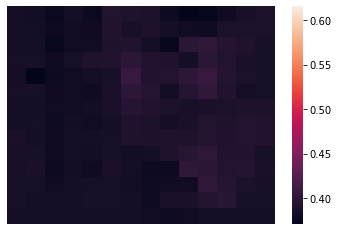

In [ ]:
#compute occlusion heatmap
ptX_train = Variable(torch.tensor(X_train)).float()
# The model is expecting Batch, Channel, Width, Height so our
# tensor needs to be rearranged
ptX_train = ptX_train.permute(0, 3, 1, 2)
ptY_train = Variable(torch.tensor(y_train))

outputs = model(ptX_train)
print(f"Outputs shape: {outputs.shape}")
outputs = nn.functional.softmax(outputs, dim=1)

prob_no_occ, _ = torch.max(outputs.data, 1)
prob_no_occ = prob_no_occ[IM_NO].item()
print(f"Prob no occ: {prob_no_occ}")

print(f"ptX_train shape: {ptX_train.shape}")
heatmap = occlusion(model, ptX_train, ptY_train[IM_NO].item(), 5, 5)

#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()


(75, 75, 3)


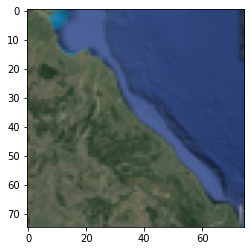

In [ ]:
%matplotlib inline
from matplotlib.pyplot import imshow
# Image.show(ptX_train[0]).convert('RGB')
print(X_train[0].shape)
imshow(X_train[IM_NO])

What occlusion represents and what it means for conclusion (not a mountain detector)

In the following code, we would like to know the general shape of the filters that the CNN is using to detect a mineral presence. So we need to grab those structures and plot their weights in graphic form.

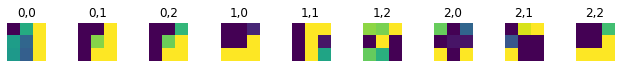

In [ ]:
'''
Code for plotting what the filters look like to demonstrate that the model
is looking for particular patterns
'''
def plot_filters_single_channel(t):
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()


def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.cnn_layers[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.cnn_layers[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        
#visualize weights for model - first conv layer
plot_weights(model, 0, single_channel = True)


And the display above demonstrates that the filters are indeed looking for specific color features in order to make their determination. In this display, the brighter the color, the higher the activation.